# RocketML Tutorial on distributed object detection on videos

## Import Libraries

In [1]:
from rocketml.io import VideoSet, MongoWriter, Video
from rocketml.feature_extraction import ObjectDetection
from rocketml.pipeline import Pipeline
import numpy as np
import sys
import os
import pymongo
from pprint import pprint
import subprocess
from time import time

In [2]:
import cv2 as cv; print('OpenCV Version:',cv.__version__)
import tensorflow as tf; print('TensorFlow Version:',tf.__version__)

('OpenCV Version:', '3.4.1-dev')
('TensorFlow Version:', '1.8.0')


In [7]:
#Simple Generator-->To clear rerun
def simple_gen():
    for x in range(100):
        yield x
        
x=simple_gen()

In [8]:
num=next(x)#<--generate the next sequence number
num

0

## Defaults


In [13]:
default_location='/home/ubuntu/test_folder/object_detection/object_detection_models_config.json'

start = time()
filename = "/home/ubuntu/rml-notebooks/home_video_list_4.txt"
# Image Set
vm = VideoSet(filename,resize_width=64,resize_height=64,frame_rate=10)

# Get uri
hname = subprocess.check_output(["hostname"])
mongo_uri = "mongodb://"+hname.strip()+":27017"

# MongoWriter
mw = MongoWriter(uri=mongo_uri,db="rml_default_database",collection="default_collection_"+str(num))

# Object Detection
od = ObjectDetection(model_type="ssd_inception_v2_coco_2017_11_17",model_framework="tensorflow",object_detection_models_config=default_location)
#od = ObjectDetection(model_type="yolo_v2",model_framework="darknet",object_detection_models_config=test_location)



# Pipeline
pipeline = Pipeline([od,mw])
pipeline.fit(vm,cores="all",verbose=True)



print("Time for object detection = %0.2f"%(time()-start))

video
------------------
Cluster Resources
------------------
Nodes        = 1
Sockets/node = 1
Cores/socket = 1
--------------------------
Total Cores    = 1
Total Memory(GB)   = 3.86
--------------------------
Time for object detection = 84.95


## Draw objects on a single video

In [14]:
vid = Video(filename="/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4")
vid.draw_objects(mw,"/home/ubuntu/test_folder/default_video_"+str(num)+".mp4")

[u'default_collection_0', u'system.indexes']


**Inspect JSON**
--------

In [15]:
import json
with open('/home/ubuntu/test_folder/object_detection/object_detection_models_config_test.json', 'r') as fp:
    data=json.load(fp)

In [16]:
data['ssd_inception_v2_coco_2017_11_17']

{u'tensorflow': {u'channel_scale_1': 127.5,
  u'channel_scale_2': 127.5,
  u'channel_scale_3': 127.5,
  u'class_names': u'/home/ubuntu/test_folder/object_detection/ssd_inception_v2_coco_2017_11_17_class_names.json',
  u'model_binary': u'/home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb',
  u'model_config': u'/home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/ssd_mobbilenet_v1_coco_2017_11_17.pbtxt',
  u'scale_factor': 0.00784313725490196,
  u'size_x': 300.0,
  u'size_y': 300.0}}

Modify JSON
=====

In [44]:
folder='ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/'

**class name**

In [45]:
location=u'/home/ubuntu/test_folder/'
data['ssd_inception_v2_coco_2017_11_17']['tensorflow']['class_names']=location+'object_detection/ssd_inception_v2_coco_2017_11_17_class_names.json'

**model binary**

In [46]:

data['ssd_inception_v2_coco_2017_11_17']['tensorflow']['model_binary']=location+folder+'frozen_inference_graph.pb'

**model config**

In [47]:
data['ssd_inception_v2_coco_2017_11_17']['tensorflow']['model_config']=location+folder+'ssd_mobbilenet_v1_coco_2017_11_17.pbtxt'

**Export JSON**

In [48]:
with open('/home/ubuntu/test_folder/object_detection/object_detection_models_config_test.json', 'w') as fp:
    json.dump(data,fp)

**View Changes**

In [49]:
import pandas as pd
#from pprint import pprint
pd.set_option('display.max_colwidth',-1)
from pandas.io.json import json_normalize
dataset=pd.DataFrame.from_dict(json_normalize(data), orient='columns')
columns=['coco_channel_scale_1','coco_channel_scale_2','coco_channel_scale_3','coco_class_names','coco_model_binary','coco_model_config','coco_scale_factor','coco_size_x','coco_size_y','yolo_channel_scale_1','yolo_channel_scale_2','yolo_channel_scale_3','yolo_class_names','yolo_model_binary','yolo_model_config','yolo_scale_factor','yolo_size_x','yolo_size_y']
dataset.columns=columns
dataset=dataset.transpose()
dataset.rename(index=str,columns={0:'Values'},inplace=True)

In [50]:
dataset

,Values
coco_channel_scale_1,127.5
coco_channel_scale_2,127.5
coco_channel_scale_3,127.5
coco_class_names,/home/ubuntu/test_folder/object_detection/ssd_inception_v2_coco_2017_11_17_class_names.json
coco_model_binary,/home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb
coco_model_config,/home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/ssd_mobbilenet_v1_coco_2017_11_17.pbtxt
coco_scale_factor,0.00784314
coco_size_x,300
coco_size_y,300
yolo_channel_scale_1,0


In [51]:
pprint(dataset.iloc[3])

Values    /home/ubuntu/test_folder/object_detection/ssd_inception_v2_coco_2017_11_17_class_names.json
Name: coco_class_names, dtype: object


In [52]:
pprint(dataset.iloc[4])

Values    /home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb
Name: coco_model_binary, dtype: object


In [53]:
pprint(dataset.iloc[5])

Values    /home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/ssd_mobbilenet_v1_coco_2017_11_17.pbtxt
Name: coco_model_config, dtype: object


## Run Modified

In [54]:
test_location='/home/ubuntu/test_folder/object_detection/object_detection_models_config_test.json'
start = time()
filename = "/home/ubuntu/rml-notebooks/home_video_list_4.txt"
# Image Set
vm = VideoSet(filename,resize_width=64,resize_height=64,frame_rate=10)

# Get uri
hname = subprocess.check_output(["hostname"])
mongo_uri = "mongodb://"+hname.strip()+":27017"

# MongoWriter
mw = MongoWriter(uri=mongo_uri,db="rml_test_databse",collection="test_collection_"+str(num))

# Object Detection
od = ObjectDetection(model_type="ssd_inception_v2_coco_2017_11_17",model_framework="tensorflow",object_detection_models_config=test_location)

#od = ObjectDetection(model_type="yolo_v2",model_framework="darknet",object_detection_models_config=test_location)



# Pipeline
pipeline = Pipeline([od,mw])
pipeline.fit(vm,cores="all",verbose=True)


print('Test Run:',num)
print("Time for object detection = %0.2f"%(time()-start))

video
------------------
Cluster Resources
------------------
Nodes        = 1
Sockets/node = 1
Cores/socket = 1
--------------------------
Total Cores    = 1
Total Memory(GB)   = 3.86
--------------------------
('Test Run:', 0)
Time for object detection = 1.50


## Draw objects on a single video

In [47]:
vid = Video(filename="/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4")
vid.draw_objects(mw,"/home/ubuntu/test_folder/test_video_"+str(num)+".mp4")

[]


TypeError: 'NoneType' object has no attribute '__getitem__'

In [261]:
import pymongo
from pymongo import MongoClient

client = MongoClient()
client = MongoClient(mongo_uri)
db = client.rml_collection_video_tf_demo
collection = db["test_run_"+str(num)]

In [262]:
myList=[]
for i in collection.find():
    myList.append(i) 
print 'The number of indexed items:',len(myList)

The number of indexed items: 2181


In [384]:
final_ids=[]
for i in range(0,len(myList)):
    together=[]
    final_ids.append(together)
    #print(i)
    obj=myList[i]['objects']
    for j in obj:
        indices=j
        id_values=[]
        double=[]
        together.append(double)
        if 'id' in indices.keys():
            id_values.append(indices['id'])
            #print(id_values)
            double.append(id_values)
        else:
            continue

In [472]:
id_column=[]
for i in range(0,len(final_ids)):
    id_column.append(np.array(pd.Series(str(final_ids[i])).str.replace('[','').str.replace(']','')))

In [507]:
import pandas as pd
#from pprint import pprint
pd.set_option('display.max_colwidth',-1)
from pandas.io.json import json_normalize


full_dataset=pd.DataFrame(columns=['_id','file_name','fps','frame_id','height','row_id','width','objectsReturned'])

for i in range(0,len(myList)): 
    
    dataset=pd.DataFrame.from_dict(json_normalize(myList[i]), orient='columns')
    dataset.drop(columns=['objects'],inplace=True)
    dataCol=pd.Series(dataset.columns)
    dataCol=dataCol.str.replace('frame_meta_data.','')
    dataset.columns=dataCol
    dataset['objectsReturned']='something'
    
    full_dataset.loc[len(full_dataset)]=dataset.loc[0]

full_dataset['objectsReturned']=id_column

In [530]:
full_dataset.head(n=25)

,_id,file_name,fps,frame_id,height,row_id,width,objectsReturned
0,5b58281858e9ba2d120f6ef2,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,0,720,0,1280,"[16, 23]"
1,5b58281858e9ba2d120f6ef3,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,1,720,1,1280,"[16, 23]"
2,5b58281858e9ba2d120f6ef4,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,2,720,2,1280,[]
3,5b58281858e9ba2d120f6ef5,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,3,720,3,1280,[]
4,5b58281858e9ba2d120f6ef6,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,4,720,4,1280,[16]
5,5b58281858e9ba2d120f6ef7,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,5,720,5,1280,[16]
6,5b58281858e9ba2d120f6ef8,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,6,720,6,1280,[21]
7,5b58281858e9ba2d120f6ef9,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,7,720,7,1280,[21]
8,5b58281858e9ba2d120f6efa,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,8,720,8,1280,[21]
9,5b58281858e9ba2d120f6efb,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,25.0,9,720,9,1280,[21]


Inspect Items
-----

In [532]:
RequestItem=0

In [533]:
myList[0]

{u'_id': ObjectId('5b58281858e9ba2d120f6ef2'),
 u'frame_meta_data': {u'file_name': u'/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4',
  u'fps': 25.0,
  u'frame_id': 0,
  u'height': 720,
  u'row_id': 0,
  u'width': 1280},
 u'objects': [{u'confidence': 0.258360534906387,
   u'height': 288.673950195312,
   u'id': 16,
   u'name': u'bird',
   u'width': 181.070068359375,
   u'x_center': 159.617218017578,
   u'y_center': 385.527770996094},
  {u'confidence': 0.260805279016495,
   u'height': 610.177062988281,
   u'id': 23,
   u'name': u'bear',
   u'width': 1043.73266601562,
   u'x_center': 545.624267578125,
   u'y_center': 308.561065673828}]}

Objects MetaData
----

In [534]:
import pandas as pd
#from pprint import pprint
pd.set_option('display.max_colwidth',-1)
from pandas.io.json import json_normalize
dataset=pd.DataFrame.from_dict(json_normalize(myList[RequestItem]), orient='columns')
heading=dataset['_id']
dataset.drop(columns=['objects','_id'],inplace=True)
dataset=dataset.transpose()
dataset.columns=heading
dataset.reset_index(inplace=True)
dataset['index']=dataset['index'].str.replace('frame_meta_data.','')
dataset.rename(columns={'index':'meta_frame'},inplace=True)
#dataset

Items found in frame
------

Needs a condition that checks if there were objects found

In [535]:
objects=pd.DataFrame.from_dict(json_normalize(myList[RequestItem]['objects']), orient='columns')
names=list(objects['name'])
objects.drop(columns=['name'],inplace=True)
objects=objects.transpose()
objects.columns=names
objects.reset_index(inplace=True)
objects.rename(columns={'index':'found_items'},inplace=True)
objects

,found_items,bird,bear
0,confidence,0.258361,0.260805
1,height,288.673950,610.177063
2,id,16.000000,23.000000
3,width,181.070068,1043.732666
4,x_center,159.617218,545.624268
5,y_center,385.527771,308.561066


In [536]:
pd.concat([dataset, objects], axis=1)

,meta_frame,5b58281858e9ba2d120f6ef2,found_items,bird,bear
0,file_name,/home/ubuntu/s3_mount/SampleVideo_1280x720_10mb.mp4,confidence,0.258361,0.260805
1,fps,25,height,288.673950,610.177063
2,frame_id,0,id,16.000000,23.000000
3,height,720,width,181.070068,1043.732666
4,row_id,0,x_center,159.617218,545.624268
5,width,1280,y_center,385.527771,308.561066


In [54]:
help(od)

Help on ObjectDetection in module rocketml.feature_extraction.object_detection object:

class ObjectDetection(rocketml.base.Node)
 |  Detects object using Pre-built Deep Learning Models
 |  
 |  Method resolution order:
 |      ObjectDetection
 |      rocketml.base.Node
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_type='yolo_v2', model_framework='darknet', min_confidence=0.24, dump_json=False, dump_json_prefix='/tmp/jobs_folder/object_detection', object_detection_models_config='/etc/rocketml.d/object_detection/object_detection_models_config.json', **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from rocketml.base.Node:
 |  
 |  get_app_info(self, data_type, _type='')
 |      Method to get a list of app names, app data types, and conig files matching this node
 |  
 |  to_dict(self)
 |      Return node as a dictionary
 |  
 |  -------------------------------------------------------

## Testing Ground


In [12]:
#!pip install --user matplotlib

In [13]:
%time
import cv2 as cv
import matplotlib.pyplot as plt
#Can get working out of the box or with tf_text_graph_ssd.py
location1='/home/ubuntu/test_folder/object_detection/' #we already have
location2='/home/ubuntu/test_folder/ssd_mobilenet_v1_coco_2017_11_17/'
location3='/home/ubuntu/test_folder/ssd_inception_v2_coco_2017_11_17/' #retrieved from https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API
location4='/home/ubuntu/test_folder/ssd_mobilenet_v1_coco_2018_01_28/'
location5='/home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/'
location12='/home/ubuntu/test_folder/ssd_mobilenet_v2_coco_2018_03_29/'
location13='/home/ubuntu/test_folder/ssdlite_mobilenet_v2_coco_2018_05_09/'
location14='/home/ubuntu/test_folder/ssd_inception_v2_coco_2018_01_28/'


#Line of doesn't work
# For use on mobile machines
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/docs_src/performance/quantization.md
location6='/home/ubuntu/test_folder/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18/'
location7='/home/ubuntu/test_folder/ssd_mobilenet_v1_0.75_depth_quantized_300x300_coco14_sync_2018_07_18/'
#
location8='/home/ubuntu/test_folder/ssd_mobilenet_v1_ppn_shared_box_predictor_300x300_coco14_sync_2018_07_03'
location9='/home/ubuntu/test_folder/ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'
location10='/home/ubuntu/test_folder/ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'
location11='/home/ubuntu/test_folder/ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'
location15='/home/ubuntu/test_folder/faster_rcnn_inception_v2_coco_2018_01_28/'
location16='/home/ubuntu/test_folder/faster_rcnn_resnet50_coco_2018_01_28/'
location17='/home/ubuntu/test_folder/faster_rcnn_resnet50_lowproposals_coco_2018_01_28/'
location18='/home/ubuntu/test_folder/rfcn_resnet101_coco_2018_05_09/'
location19='/home/ubuntu/test_folder/faster_rcnn_resnet101_coco_2018_01_28/'
location20='/home/ubuntu/test_folder/faster_rcnn_resnet101_lowproposals_coco_2018_01_28/'
location21='/home/ubuntu/test_folder/faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/'
location22='/home/ubuntu/test_folder/faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco_2018_01_28/'
location23='/home/ubuntu/test_folder/faster_rcnn_nas_coco_2018_01_28/'
location24='/home/ubuntu/test_folder/faster_rcnn_nas_lowproposals_coco_2018_01_28/'
location25='/home/ubuntu/test_folder/mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/'
location26='/home/ubuntu/test_folder/mask_rcnn_inception_v2_coco_2018_01_28/'
location27='/home/ubuntu/test_folder/mask_rcnn_resnet101_atrous_coco_2018_01_28/'
location28='/home/ubuntu/test_folder/mask_rcnn_resnet50_atrous_coco_2018_01_28/'



cvNet = cv.dnn.readNetFromTensorflow(location6+'tflite_graph.pb', location6+'tflite_graph.pbtxt')

img = cv.imread('picture1.jpg')
rows = img.shape[0]
cols = img.shape[1]
cvNet.setInput(cv.dnn.blobFromImage(img, 1.0/127.5, (300, 300), (127.5, 127.5, 127.5), swapRB=True, crop=False))
cvOut = cvNet.forward()

for detection in cvOut[0,0,:,:]:
    score = float(detection[2])
    if score > 0.3:
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        cv.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (23, 230, 210), thickness=2)

plt.imshow(img)
plt.show()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs


error: OpenCV(3.4.1-dev) /tmp/opencv/modules/dnn/src/tensorflow/tf_importer.cpp:549: error: (-215) Assertion failed: const_layers.insert(std::make_pair(name, li)).second in function addConstNodes


In [3]:
!pip install --user matplotlib
!sudo pip install image
!sudo git clone https://github.com/tensorflow/models.git
!sudo apt-get -qq install libprotobuf-java protobuf-compiler
!sudo protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -r /home/ubuntu/rml-notebooks/models/research/object_detection /home/ubuntu/rml-notebooks
!sudo rm -rf models

    100% |████████████████████████████████| 12.6MB 110kB/s eta 0:00:01
    100% |████████████████████████████████| 952kB 1.4MB/s eta 0:00:01
    100% |████████████████████████████████| 102kB 11.5MB/s a 0:00:01
  Running setup.py bdist_wheel for subprocess32 ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/b1/a2/4d/25a65a64749cd589ffae2fdd1a7baa15a3986a8ea8af48feaf
Successfully built subprocess32
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If execu

In [66]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# This is needed to display the images.
%matplotlib inline

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
print(tf.__version__)

1.8.0


In [67]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [78]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

MODEL_FILE = MODEL_NAME + '.tar.gz'#ssd_mobilenet_v1_coco_2017_11_17.tar.gz

DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/' #location for model download (tensorflow zoo)

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt') #object_detection/data/mscoco_label_map.pbtxt

NUM_CLASSES = 90

In [85]:
opener = urllib.request.URLopener()

opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
print('file location: '+DOWNLOAD_BASE)
print('file to download: '+ MODEL_FILE)

file location: http://download.tensorflow.org/models/object_detection/
file to download: ssd_mobilenet_v1_coco_2017_11_17.tar.gz


In [87]:
graph_file='frozen_inference_graph.pb'
tar_file = tarfile.open(MODEL_FILE) #Open tar file

In [103]:
for file in tar_file.getmembers(): #print file contents
    print(os.path.basename(file.name))
print('Current working directory:'+os.getcwd())

ssd_mobilenet_v1_coco_2017_11_17
model.ckpt.index
model.ckpt.meta
frozen_inference_graph.pb
model.ckpt.data-00000-of-00001
saved_model
saved_model.pb
variables
checkpoint
Current working directory:/home/ubuntu/rml-notebooks


In [110]:
for file in tar_file.getmembers(): #open file contents
    file_name = os.path.basename(file.name)
    if graph_file in file_name: #if the graph_file is in the .tar then extract it to current working directory
        tar_file.extract(file, os.getcwd())

In [111]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [72]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)

categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, 
                                                            use_display_name=True)

category_index = label_map_util.create_category_index(categories)

In [130]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [148]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/home/ubuntu/test_images'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR,'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [149]:
TEST_IMAGE_PATHS

['/home/ubuntu/test_images/image1.jpg', '/home/ubuntu/test_images/image2.jpg']

In [150]:
def run_inference_for_single_image(image, graph):
    
    with graph.as_default():
        
        with tf.Session() as sess:
          # Get handles to input and output tensors
          ops = tf.get_default_graph().get_operations()
            
          all_tensor_names = {output.name for op in ops for output in op.outputs}
        
          tensor_dict = {} 
          for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
            tensor_name = key + ':0'
            
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
                
          image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
          output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

          # all outputs are float32 numpy arrays, so convert types as appropriate
          output_dict['num_detections'] = int(output_dict['num_detections'][0])
          output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
          output_dict['detection_scores'] = output_dict['detection_scores'][0]
            
          if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
            
    return output_dict

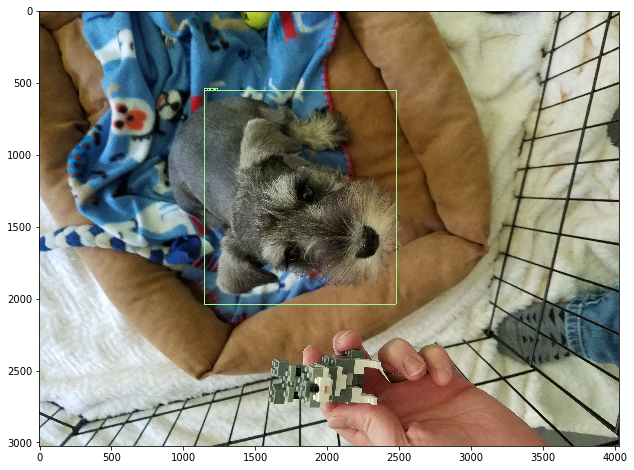

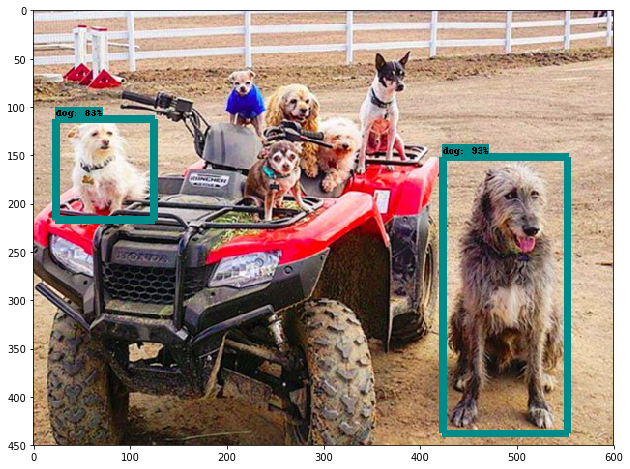

In [151]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(image_np,output_dict['detection_boxes'],
                                                     output_dict['detection_classes'],
                                                     output_dict['detection_scores'],
                                                     category_index,
                                                     instance_masks=output_dict.get('detection_masks'),
                                                     use_normalized_coordinates=True,
                                                     line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)